## Setup environment

In [118]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

## Setup imports

In [119]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from monai.transforms import FillHoles, BoundingRect
import os
import tempfile
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset
from monai.losses import HoVerNetLoss
from monai.metrics import DiceMetric
from monai.networks.nets import HoVerNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    AsDiscreted,
    Compose,
    ScaleIntensityRanged,
    CastToTyped,
    Lambdad,
    SplitDimd,
    EnsureChannelFirstd,
    ComputeHoVerMapsd,
    RandFlipd,
    RandRotate90d,
    RandGaussianSmoothd,
    FillHoles,
    BoundingRect,
)
from monai.apps.pathology.transforms.post.array import (
    GenerateInstanceCentroid, 
    GenerateInstanceContour, 
    GenerateInstanceType,
)
from monai.utils import set_determinism, convert_to_tensor, first
from monai.utils.enums import HoVerNetBranch
from sklearn.model_selection import StratifiedShuffleSplit

import torch

print_config()

MONAI version: 1.0.0+99.g919235ff.dirty
Numpy version: 1.22.4
Pytorch version: 1.13.0a0+d321be6
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 919235ffcba796c2b154fed3e34559dfd121e91f
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.1
gdown version: 4.5.1
TorchVision version: 0.14.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.21.3
mlflow version: 1.28.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [120]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Set deterministic training for reproducibility

In [121]:
set_determinism(seed=0)

## Process dataset

In [122]:
def prepare_datasets(data_dir):
    info = pd.read_csv(os.path.join(data_dir, "patch_info.csv"))
    file_names = np.squeeze(info.to_numpy()).tolist()

    img_sources = [v.split("-")[0] for v in file_names]
    img_sources = np.unique(img_sources)

    cohort_sources = [v.split("_")[0] for v in img_sources]
    _, cohort_sources = np.unique(cohort_sources, return_inverse=True)

    splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=0)

    split_generator = splitter.split(img_sources, cohort_sources)
    for train_indices, valid_indices in split_generator:
        train_cohorts = img_sources[train_indices]
        valid_cohorts = img_sources[valid_indices]
        if np.intersect1d(train_cohorts, valid_cohorts).size != 0:
            raise ValueError("Train and validation cohorts has an overlap.")
        train_names = [
            file_name for file_name in file_names for source in train_cohorts if source == file_name.split("-")[0]
        ]
        valid_names = [
            file_name for file_name in file_names for source in valid_cohorts if source == file_name.split("-")[0]
        ]
        train_names = np.unique(train_names)
        valid_names = np.unique(valid_names)
        print(f"Train: {len(train_names):04d} - Valid: {len(valid_names):04d}")
        if np.intersect1d(train_names, valid_names).size != 0:
            raise ValueError("Train and validation cohorts has an overlap.")

        train_indices = [file_names.index(v) for v in train_names]
        valid_indices = [file_names.index(v) for v in valid_names]

    images = np.load(os.path.join(data_dir, "images.npy"))
    labels = np.load(os.path.join(data_dir, "labels.npy"))

    data = [
        {
            "image": image,
            "image_meta_dict": {"original_channel_dim": -1},
            "label": label,
            "label_meta_dict": {"original_channel_dim": -1},
        }
        for image, label in zip(images, labels)
    ]

    train_data = [data[i] for i in train_indices]
    valid_data = [data[i] for i in valid_indices]

    return train_data, valid_data

## Setup transforms for training and validation

In [123]:
def cropping_center(x, crop_shape, batch=False):
    """Crop an input image at the centre.
    Args:
        x: input array
        crop_shape: dimensions of cropped array

    Returns:
        x: cropped array

    """
    orig_shape = x.shape
    if not batch:
        h0 = int((orig_shape[1] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[2] - crop_shape[1]) * 0.5)
        x = x[:, h0: h0 + crop_shape[0], w0: w0 + crop_shape[1]]
    else:
        h0 = int((orig_shape[2] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[3] - crop_shape[1]) * 0.5)
        x = x[..., h0: h0 + crop_shape[0], w0: w0 + crop_shape[1]]
    return x

In [124]:
train_transforms = Compose(
    [
        EnsureChannelFirstd(keys=("image", "label"), channel_dim=-1),
        SplitDimd(keys="label", output_postfixes=["inst", "type"]),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type", "hover_label_inst"], dtype=torch.float32),
        Lambdad(keys="label", func=lambda x: x[1: 2, ...] > 0),
        AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 7]),
        CenterSpatialCropd(keys=["label", "label_inst", "label_type", "hover_label_inst"], roi_size=(164,164)),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        RandFlipd(keys=["image", "label", "label_inst", "label_type", "hover_label_inst"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label", "label_inst", "label_type", "hover_label_inst"], prob=0.5, spatial_axis=1),
        RandRotate90d(keys=["image", "label", "label_inst", "label_type", "hover_label_inst"], prob=0.5, max_k=1),
        RandGaussianSmoothd(keys=["image"], sigma_x=(0.5,1.15), sigma_y=(0.5,1.15), prob=0.5),
    ]
)
val_transforms = Compose(
    [
        EnsureChannelFirstd(keys=("image", "label"), channel_dim=-1),
        SplitDimd(keys="label", output_postfixes=["inst", "type"]),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type", "hover_label_inst"], dtype=torch.float32),
        Lambdad(keys="label", func=lambda x: x[1: 2, ...] > 0),
        AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 7]),
        CenterSpatialCropd(keys=["label", "label_inst", "label_type", "hover_label_inst"], roi_size=(164,164)),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)

## Define Dataset and DataLoader for training and validation

In [125]:
data_dir = os.path.join(root_dir, 'Lizard/Prepared')

train_data, valid_data = prepare_datasets(data_dir)
train_ds = Dataset(data=train_data, transform=train_transforms)
valid_ds = Dataset(data=valid_data, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=8, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size=6, num_workers=4, pin_memory=True)

Train: 3900 - Valid: 1081


## Check first data shape and visualize

image: 
    shape (8, 3, 256, 256)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
label: 
    shape (8, 2, 164, 164)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
hover_label_inst: 
    shape (8, 2, 164, 164)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
train number of batches: 488
valid number of batches: 181


Text(0.5, 1.0, 'vertical hover map')

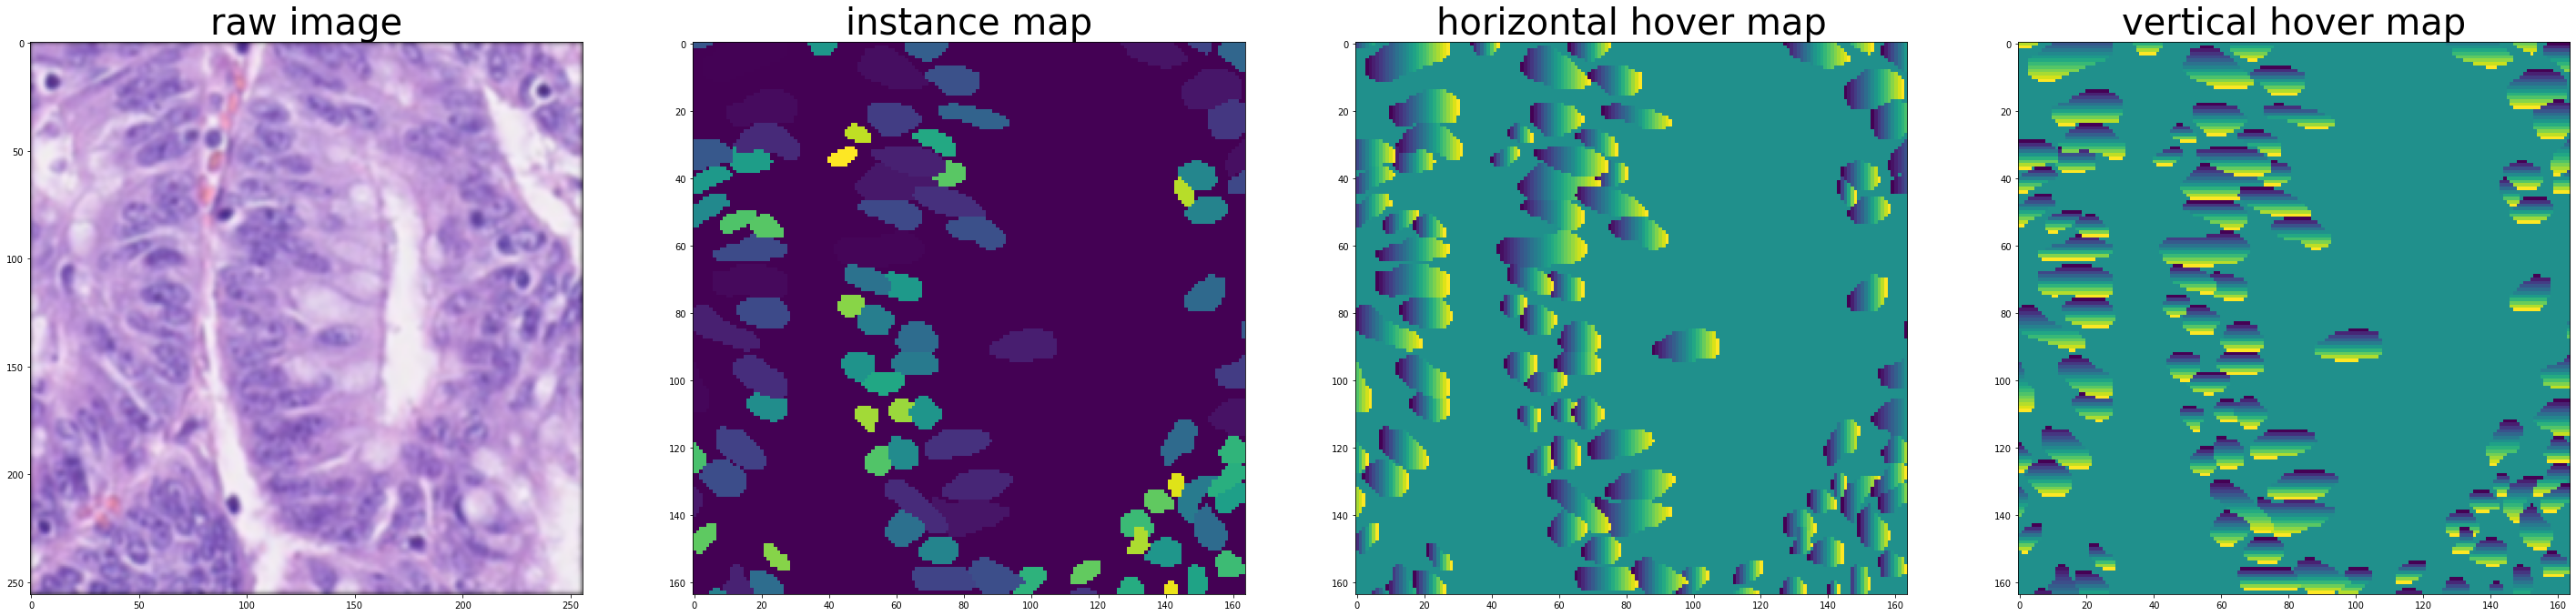

In [126]:
first_sample = first(train_loader)
for k in ("image", "label", "hover_label_inst"):
    print(f"{k}: ")
    print("    shape", first_sample[k].shape)
    print("    type: ", type(first_sample[k]))
    print("    dtype: ", first_sample[k].dtype)
print(f"train number of batches: {len(train_loader)}")
print(f"valid number of batches: {len(val_loader)}")

fig, ax = plt.subplots(1, 4, figsize=(50, 25))
ax[0].imshow((first_sample['image'][0, ...] * 255).astype(np.uint8).transpose(1, 2, 0))
ax[1].imshow(first_sample['label_inst'][0, ...].squeeze())
ax[2].imshow(first_sample['hover_label_inst'][0, 0, ...])
ax[3].imshow(first_sample['hover_label_inst'][0, 1, ...])
ax[0].set_title('raw image', fontsize=40)
ax[1].set_title('instance map', fontsize=40)
ax[2].set_title('horizontal hover map', fontsize=40)
ax[3].set_title('vertical hover map', fontsize=40)

## Create Model, Loss, Optimizer

In [129]:
device = torch.device("cuda:1")
model = HoVerNet(
    mode="fast",
    in_channels=3,
    out_classes=7,
    act=("relu", {"inplace": True}),
    norm="batch",
    dropout_prob=0.2,
).to(device)
loss_function = HoVerNetLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [11]:
max_epochs = 300
val_interval = 2
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], []]
epoch_loss_values = []
metric_values = []

post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, label, label_type, hover_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["label_type"].to(device),
            batch_data["hover_label_inst"].to(device),
        )

        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: label_type,
        }
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_label, val_label_type, val_hover_map = (
                    batch_data["image"].to(device),
                    batch_data["label"].to(device),
                    batch_data["label_type"].to(device),
                    batch_data["hover_label_inst"].to(device),
                )

                val_outputs = model(val_inputs)
                val_outputs = [post_pred(i['nucleus_prediction']) for i in decollate_batch(val_outputs)]
                val_label = [i for i in decollate_batch(val_label)]

                dice_metric(y_pred=val_outputs, y=val_label)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(data_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300
epoch 1 average loss: 10.3481
time consuming of epoch 1 is: 319.2701
----------
epoch 2/300
epoch 2 average loss: 8.6547
saved new best metric model
current epoch: 2 current mean dice: 0.5490
best mean dice: 0.5490 at epoch: 2
time consuming of epoch 2 is: 334.5566
----------
epoch 3/300
epoch 3 average loss: 8.0543
time consuming of epoch 3 is: 319.2713
----------
epoch 4/300
epoch 4 average loss: 7.6946
saved new best metric model
current epoch: 4 current mean dice: 0.6792
best mean dice: 0.6792 at epoch: 4
time consuming of epoch 4 is: 334.5972
----------
epoch 5/300
epoch 5 average loss: 7.4242
time consuming of epoch 5 is: 318.5370
----------
epoch 6/300
epoch 6 average loss: 7.1902
saved new best metric model
current epoch: 6 current mean dice: 0.7604
best mean dice: 0.7604 at epoch: 6
time consuming of epoch 6 is: 334.6743
----------
epoch 7/300
epoch 7 average loss: 6.9863
time consuming of epoch 7 is: 319.3107
----------
epoch 8/300
epoch 8 average loss:

KeyboardInterrupt: 

In [84]:

post_trans_seg = Compose([
    GenerateWatershedMaskd(keys=HoVerNetBranch.NP.value, softmax=True),
    GenerateInstanceBorderd(keys='mask', hover_map_key=HoVerNetBranch.HV, kernel_size=3),
    GenerateDistanceMapd(keys='mask', border_key='border', smooth_fn="gaussian"),
    GenerateWatershedMarkersd(keys='mask', border_key='border', threshold=0.7, radius=2, postprocess_fn=FillHoles()),
    Watershedd(keys='dist', mask_key='mask', markers_key='markers')
])


def post_process(output, return_centroids=True, output_classes=7):
    if HoVerNetBranch.NC.value in output.keys():
        type_pred = Activations(softmax=True)(output[HoVerNetBranch.NC.value])
        type_pred = AsDiscrete(argmax=True)(output[HoVerNetBranch.NC.value])

    pred_inst_dict = post_trans_seg(output)
    pred_inst = pred_inst_dict['dist']

    inst_id_list = np.unique(pred_inst)[1:]  # exclude background

    inst_info_dict = None
    if return_centroids:
        inst_id_list = np.unique(pred_inst)[1:]  # exclude background
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            inst_bbox = BoundingRect()(inst_map)
            inst_map = inst_map[:, inst_bbox[0][0]: inst_bbox[0][1], inst_bbox[0][2]: inst_bbox[0][3]]
            offset = [inst_bbox[0][2], inst_bbox[0][0]]
            inst_contour = GenerateInstanceContour()(inst_map.squeeze(), offset)
            inst_centroid = GenerateInstanceCentroid()(inst_map, offset)
            if inst_contour is not None:
                inst_info_dict[inst_id] = {  # inst_id should start at 1
                    "bounding_box": inst_bbox,
                    "centroid": inst_centroid,
                    "contour": inst_contour,
                    "type_probability": None,
                    "type": None,
                }

    if output_classes is not None:
        for inst_id in list(inst_info_dict.keys()):
            inst_type, type_prob = GenerateInstanceType()(
                bbox=inst_info_dict[inst_id]["bounding_box"], type_pred=type_pred, seg_pred=pred_inst, instance_id=inst_id)
            inst_info_dict[inst_id]["type"] = inst_type
            inst_info_dict[inst_id]["type_probability"] = type_prob

    pred_inst = convert_to_tensor(pred_inst, device=device)
    return (pred_inst, inst_info_dict, pred_inst_dict)

## Check best model output with the input image and label

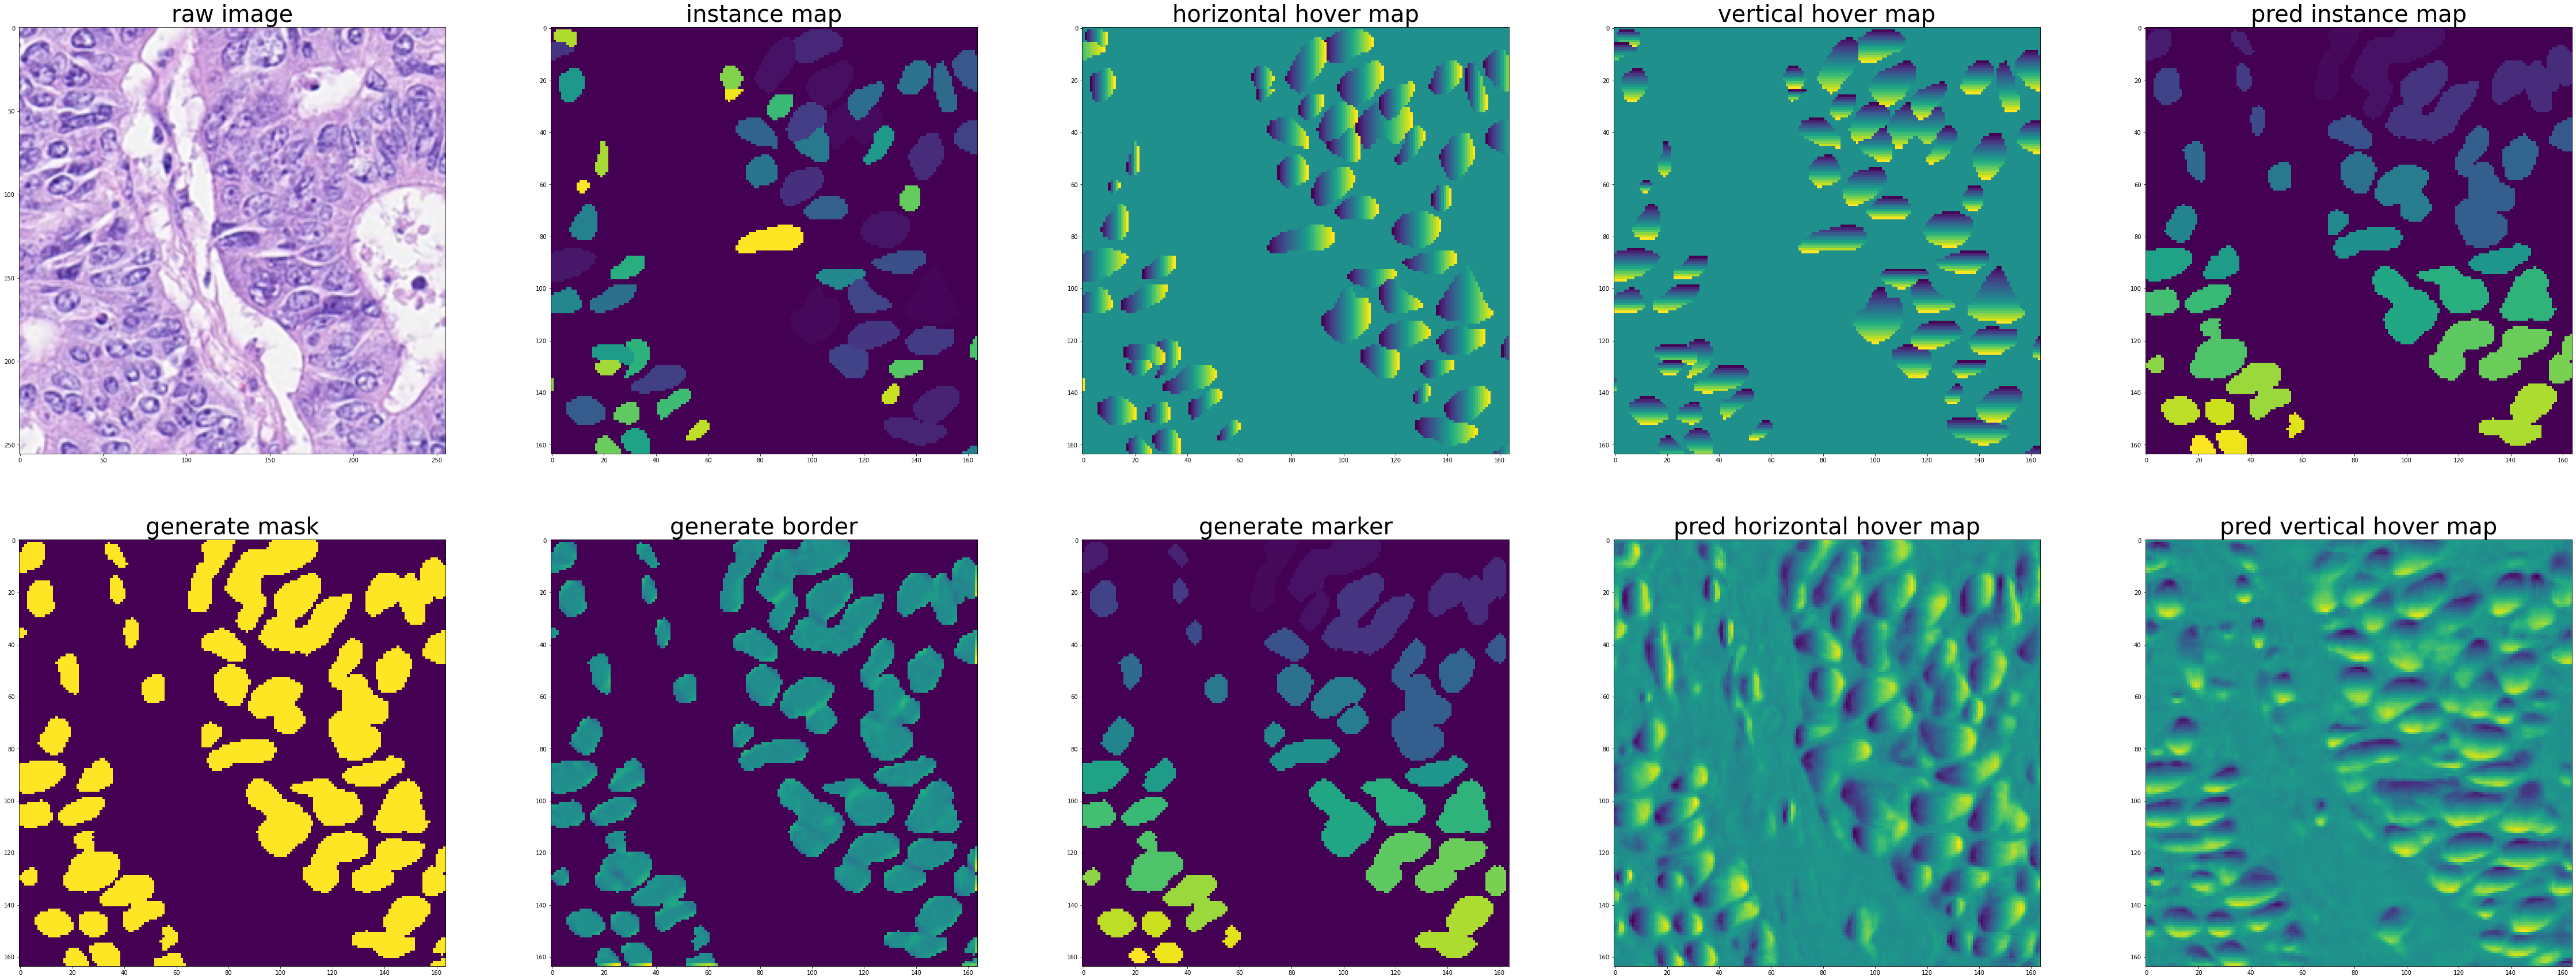

In [132]:
import sys
sys.path.append("/workspace/Code/tutorials/pathology/hovernet/transforms")
from transforms import (
    GenerateWatershedMaskd,
    GenerateInstanceBorderd,
    GenerateDistanceMapd,
    GenerateWatershedMarkersd,
    Watershedd,
    GenerateInstanceContour,
    GenerateInstanceCentroid,
    GenerateInstanceType,
)
def post_process(output, return_centroids=True, output_classes=7):
    if HoVerNetBranch.NC.value in output.keys():
        type_pred = Activations(softmax=True)(output[HoVerNetBranch.NC.value])
        type_pred = AsDiscrete(argmax=True)(output[HoVerNetBranch.NC.value])

    post_trans_seg = Compose([
        GenerateWatershedMaskd(keys=HoVerNetBranch.NP.value, softmax=True),
        GenerateInstanceBorderd(keys='mask', hover_map_key=HoVerNetBranch.HV, kernel_size=3),
        GenerateDistanceMapd(keys='mask', border_key='border', smooth_fn="gaussian"),
        GenerateWatershedMarkersd(keys='mask', border_key='border', threshold=0.6, radius=2, postprocess_fn=FillHoles()),
        Watershedd(keys='dist', mask_key='mask', markers_key='markers')
    ])
    pred_inst_dict = post_trans_seg(output)
    pred_inst = pred_inst_dict['dist']

    inst_id_list = np.unique(pred_inst)[1:]  # exclude background

    inst_info_dict = None
    if return_centroids:
        inst_id_list = np.unique(pred_inst)[1:]  # exclude background
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            inst_bbox = BoundingRect()(inst_map)
            inst_map = inst_map[:, inst_bbox[0][0]: inst_bbox[0][1], inst_bbox[0][2]: inst_bbox[0][3]]
            offset = [inst_bbox[0][2], inst_bbox[0][0]]
            inst_contour = GenerateInstanceContour()(inst_map.squeeze(), offset)
            inst_centroid = GenerateInstanceCentroid()(inst_map, offset)
            if inst_contour is not None:
                inst_info_dict[inst_id] = {  # inst_id should start at 1
                    "bounding_box": inst_bbox,
                    "centroid": inst_centroid,
                    "contour": inst_contour,
                    "type_probability": None,
                    "type": None,
                }

    if output_classes is not None:
        for inst_id in list(inst_info_dict.keys()):
            inst_type, type_prob = GenerateInstanceType()(
                bbox=inst_info_dict[inst_id]["bounding_box"], type_pred=type_pred, seg_pred=pred_inst, instance_id=inst_id)
            inst_info_dict[inst_id]["type"] = inst_type
            inst_info_dict[inst_id]["type_probability"] = type_prob

    pred_inst = convert_to_tensor(pred_inst, device=device)
    return (pred_inst, inst_info_dict, pred_inst_dict)

# test postprocess transform 
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = valid_ds[0]["image"].unsqueeze(0).to(device)

    val_output = model(val_input)
    val_output_ = [post_process(i) for i in decollate_batch(val_output)]

    fig, ax = plt.subplots(2, 5, figsize=(80, 30))
    ax[0, 0].imshow(val_input.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
    ax[0, 1].imshow(valid_ds[0]["label_inst"].squeeze().detach().cpu())
    ax[0, 2].imshow(valid_ds[0]["hover_label_inst"][0, ...].detach().cpu())
    ax[0, 3].imshow(valid_ds[0]["hover_label_inst"][1, ...].detach().cpu())
    ax[0, 4].imshow(val_output_[0][0].squeeze().detach().cpu())

    ax[1, 0].imshow(val_output_[0][2]["mask"].detach().cpu().squeeze())
    ax[1, 1].imshow(val_output_[0][2]["border"].detach().cpu().squeeze())
    ax[1, 2].imshow(val_output_[0][2]["markers"].detach().cpu().squeeze())
    ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
    ax[1, 4].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

    ax[0, 0].set_title('raw image', fontsize=40)
    ax[0, 1].set_title('instance map', fontsize=40)
    ax[0, 2].set_title('horizontal hover map', fontsize=40)
    ax[0, 3].set_title('vertical hover map', fontsize=40)
    ax[0, 4].set_title('pred instance map', fontsize=40)
    ax[1, 0].set_title('generate mask', fontsize=40)
    ax[1, 1].set_title('generate border', fontsize=40)
    ax[1, 2].set_title('generate marker', fontsize=40)
    ax[1, 3].set_title('pred horizontal hover map', fontsize=40)
    ax[1, 4].set_title('pred vertical hover map', fontsize=40)